In [1]:
""" STDP based Associative Memory Neural Network """

# 필요 패키지 준비 및 모듈 구성

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

IMAGE_SIZE = 32  # size of images (width & height)
IMAGE_PIXEL_THRESHOLD = .05  # threshold for pixel values


def gram_schmidt_process(V: np.ndarray) -> np.ndarray:
    n, N = V.shape
    U = np.zeros((n, N), dtype=np.float64)
    U[0] = V[0] / np.linalg.norm(V[0])
    for i in range(1, n):    
        a = np.zeros((N,), dtype=np.float64)
        for j in range(i):
            a += np.dot(V[i], U[j]) * U[j]
        U[i] = V[i] - a
        U[i] = U[i] / np.linalg.norm(U[i])
    return U


def encode_images(img_paths: str, tags: np.ndarray) -> np.ndarray:
    """ encode images to neural states (memory components) """

    d = IMAGE_SIZE
    num_comp = len(img_paths)
    dim = (d ** 2) * tags.shape[1]
    mem_comp = np.zeros((num_comp, dim))
    for i, (img_path, tag) in enumerate(zip(img_paths, tags)):
        img = Image.open(img_path).convert("L")
        img = img.resize((d, d))
        img_values = np.array(img) / 255
        img_values = (img_values - 0.5) * (2 * IMAGE_PIXEL_THRESHOLD)
        img_values = np.reshape(img_values, (d ** 2,))
        mem_comp[i] = np.outer(tag, img_values).reshape(-1)  # tensor product binding
    return mem_comp


def decode_neural_state(x: np.ndarray, tags: np.ndarray) -> plt.Figure:
    """ decode neural state x to images """

    d = IMAGE_SIZE
    th = IMAGE_PIXEL_THRESHOLD / 2
    n = len(tags)
    fig, axes = plt.subplots(1, n, figsize=(1 * n, 1))
    if len(tags) == 1:
        axes = [axes]
    for tag, ax in zip(tags, axes):
        ax: plt.Axes
        decoded = tag @ np.reshape(x, (-1, d ** 2))
        decoded = np.reshape(decoded, (d, d))
        decoded[decoded > th] = th
        decoded[decoded < -th] = -th
        ax.imshow(decoded, cmap="gray", vmin=-th, vmax=th)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    return fig


class AssociativeMemoryNN:
    def __init__(self, dim: int, omega: float, gamma: float, rho: float):
        self.dim = dim        
        self.omega = omega
        self.gamma = gamma  # decay rate of W
        self.rho = rho  # learning rate of W
        self.tau = np.pi / (2 * self.omega)  # best theoretical delay for STDP

        self.x_window: np.ndarray = None  # buffer for delayed-feedback
        self.W: np.ndarray = None  # weight matrix

    def save_W(self, path: str) -> None:
        np.save(path, self.W)

    def load_W(self, path: str) -> None:
        self.W = np.load(path)

    def _construct_learning_input(self, mem_comp: np.ndarray, T: float, dt: float) -> np.ndarray:
        """ constructing harmonic signal b(t) = sum_i sin(omega t - xi_i) * mem_comp_i """

        n, dim = mem_comp.shape
        xi = np.linspace(0, np.pi, n + 1)[:-1]
        t = np.arange(0, T, dt)
        b = np.zeros((len(t), dim))
        for i in range(n):
            b = b + np.outer(np.sin(self.omega * t - xi[i]), mem_comp[i])
        return b

    def learn_memory(self, mem_comp: np.ndarray, T: float, dt: float) -> np.ndarray:
        """ learning memory components """

        # constructing learning singal
        b = self._construct_learning_input(mem_comp, T, dt)
        # tau_timestep: a number of timesteps for delayed-feedback
        self.tau_timestep = int(np.ceil(self.tau / dt))
        # x_window: a buffer for functional initial condition to compute delayed-feedback
        self.x_window = 1e-4 * np.random.randn(self.tau_timestep + 1, self.dim)
        self.W = 1e-6 * np.random.randn(self.dim, self.dim)

        # Integation by Euler method with delayed-feedback
        for t in tqdm(range(len(b))):
            # x'(t) = -x(t) + Wx(t) + b(t)
            # W'(t) = -gamma W(t) + rho (x(t)x(t-tau)^T - x(t-tau)x(t)^T)
            x_t = self.x_window[-1]
            x_tau = self.x_window[-self.tau_timestep - 1]
            x_new = self.x_window[-1] + (
                -x_t +self.W @ x_t + b[t]
            ) * dt
            W_new = self.W + (
                -self.gamma * self.W + self.rho * (np.outer(x_tau, x_t) - np.outer(x_t, x_tau))
            ) * dt
            # update
            self.x_window[-1] = x_new
            self.x_window[:-1] = self.x_window[1:]
            self.W = W_new

    def retrieve_from_cue(self, cue: np.ndarray, tags: np.ndarray, decode_timings: list[float]) -> None:
        """ retrieval from cue signal """

        dt = 0.01
        timesteps = np.arange(0, decode_timings[-1] + dt, dt)
        b_cue = np.outer(np.sin(self.omega * timesteps), cue)
        x = 1e-3 * np.random.randn(self.dim)

        decode_timing_ct = 0
        decode_timing = decode_timings[decode_timing_ct]
        for i, t in enumerate(tqdm(timesteps)):
            # Euler method
            x_new = x + (-x + self.W @ x + b_cue[i]) * dt
            x = x_new
            if np.abs(t - decode_timing) < dt:
                fig = decode_neural_state(x, tags)
                fig.suptitle(f"Retrieved images at t = {t:.2f}", fontsize=8)
                plt.show()
                plt.close()
                if decode_timing_ct == len(decode_timings) - 1:
                    break
                decode_timing_ct += 1
                decode_timing = decode_timings[decode_timing_ct]

Images to store:


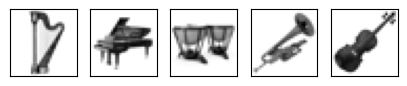

In [2]:
# 모델에 저장할 이미지 준비

img_paths = glob("images/*.png")
store_img_paths = [p for p in img_paths if "forest" not in p]  # forest 사진 제외 악기 사진 5개 사용
store_img_paths.sort()

print("Images to store:")
fig, axes = plt.subplots(1, len(store_img_paths), figsize=(1 * len(store_img_paths), 1))
for img_path, ax in zip(store_img_paths, axes):
    ax: plt.Axes
    img = Image.open(img_path).convert("L").resize((IMAGE_SIZE, IMAGE_SIZE))  # (32 x 32로 resizing)
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
plt.close()

In [3]:
# Retrieval을 위해 이미지를 디코딩할 memory tag 준비
n = len(img_paths)
print(f"Number of images: {n}")

mem_tags = np.random.randn(n, n)
# Gram-schmidt process로 orthogonalize
mem_tags = gram_schmidt_process(mem_tags)

np.save("mem_tags.npy", mem_tags)  # saving memory tags (optional)
# mem_tags = np.load("mem_tags.npy")  # loading memory tags (optional)

print(f"Random generated memory tags:\n{mem_tags}")
print(f"Memory tags shape: {mem_tags.shape}")

Number of images: 6
Random generated memory tags:
[[-0.09218085  0.20528631  0.5094141  -0.46900541 -0.57679509  0.37040362]
 [ 0.29615698  0.49035335  0.47632694  0.65071761  0.09209702  0.11420164]
 [-0.55998588  0.73650801 -0.30430236 -0.11088953  0.19475922  0.03382606]
 [-0.51417739 -0.3660566   0.41310931  0.06437675  0.51911814  0.39665712]
 [-0.56985794 -0.1774753   0.0626304   0.4838246  -0.53359672 -0.34789391]
 [-0.03306193  0.09732499  0.49641528 -0.32568915  0.25823499 -0.7551476 ]]
Memory tags shape: (6, 6)


In [4]:
# memory components로 학습용 이미지를 nerual state로 인코딩

mem_components = encode_images(store_img_paths, mem_tags[:-1])

print(f"Encoded memory components shape: {mem_components.shape}")

Encoded memory components shape: (5, 6144)


In [5]:
# 이미지 학습

omega = 1.5  # frequency of learning signal

nn = AssociativeMemoryNN(  # NN 구축
    dim=mem_components.shape[-1],
    omega=omega,
    gamma=1,
    rho=1,
)

print("Learning memory components...")
nn.learn_memory(mem_components, T=30, dt=0.1)

nn.save_W("W.npy")  # saving learned weight matrix (optional)
# nn.load_W("W.npy")  # loading learned weight matrix (optional)

Learning memory components...


100%|██████████| 300/300 [02:11<00:00,  2.28it/s]


Relevant noised cue signal:


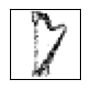

In [6]:
# noisy cue signal 준비

relevant_noised_cue = mem_components[0] \
    + 0.01 * np.random.randn(mem_components.shape[-1])  # 노이즈도 추가

print("Relevant noised cue signal:")
decode_neural_state(relevant_noised_cue, [mem_tags[0]])
plt.show()
plt.close()

In [7]:
# Perfect-retrieval 이 일어나는 시점들(t_daggers, from Theorem 3)을 정의

t_daggers = [
    (1 / omega) * np.arctan(omega) + n * np.pi / omega
    for n in range(5)
]

for i in range(len(t_daggers)):
    print(f"t_dagger_{i} = {t_daggers[i]:.2f}")

t_dagger_0 = 0.66
t_dagger_1 = 2.75
t_dagger_2 = 4.84
t_dagger_3 = 6.94
t_dagger_4 = 9.03


Retrieving images from the cue signal...


  0%|          | 0/905 [00:00<?, ?it/s]

  4%|▍         | 37/905 [00:00<00:02, 369.86it/s]

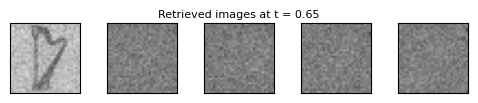

 29%|██▉       | 262/905 [00:00<00:01, 346.74it/s]

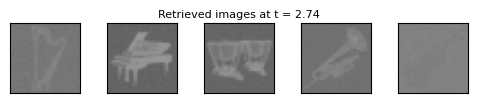

 53%|█████▎    | 477/905 [00:01<00:01, 314.00it/s]

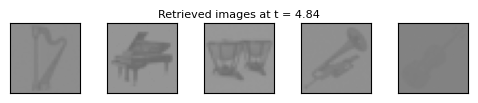

 76%|███████▌  | 686/905 [00:02<00:00, 273.68it/s]

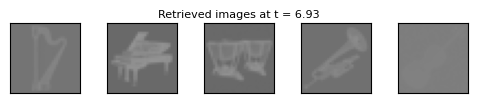

 97%|█████████▋| 882/905 [00:03<00:00, 300.70it/s]

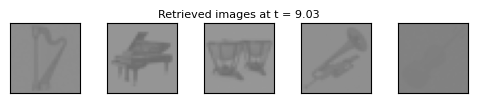

100%|█████████▉| 903/905 [00:03<00:00, 269.09it/s]


In [8]:
# cue signal을 사용해 perfect-retrieval 타이밍에 이미지 복원

print("Retrieving images from the cue signal...")
nn.retrieve_from_cue(relevant_noised_cue, mem_tags[:-1], decode_timings=t_daggers)

  0%|          | 0/501 [00:00<?, ?it/s]

  6%|▌         | 31/501 [00:00<00:01, 302.99it/s]

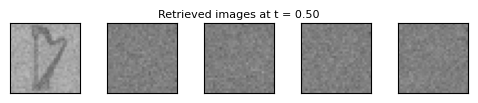

 33%|███▎      | 164/501 [00:00<00:01, 297.00it/s]

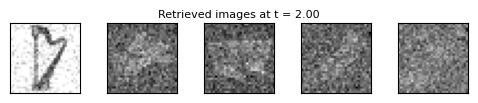

 69%|██████▉   | 348/501 [00:01<00:00, 328.31it/s]

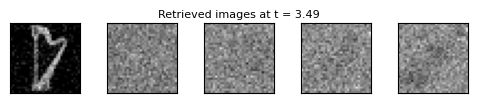

 96%|█████████▋| 483/501 [00:01<00:00, 298.95it/s]

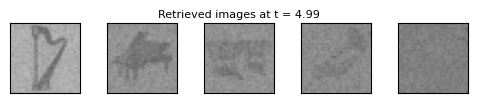

100%|█████████▉| 499/501 [00:02<00:00, 245.27it/s]


In [10]:
# 임의 retrieval 시점에 이미지 복원
nn.retrieve_from_cue(relevant_noised_cue, mem_tags[:-1], decode_timings=[0.5, 2.0, 3.5, 5.0])

Irrelevant cue image:


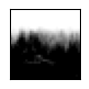

In [11]:
# 학습한 이미지와 관계없는 이미지(Irrelevant cue)로 인출 시도

irrelevant_img = Image.open("images/5_forest.png").convert("L")
irrelevant_img = irrelevant_img.resize((IMAGE_SIZE, IMAGE_SIZE))
irrelevant_img = np.array(irrelevant_img) / 255
irrelevant_img = np.reshape(irrelevant_img, (IMAGE_SIZE ** 2,))
irrelevant_img = (irrelevant_img - 0.5) * (2 * IMAGE_PIXEL_THRESHOLD)
irrelevant_cue = np.outer(mem_tags[-1], irrelevant_img).reshape(-1)

print("Irrelevant cue image:")
decode_neural_state(irrelevant_cue, [mem_tags[-1]])
plt.show()
plt.close()

Retrieving images with irrelevant tag...


  4%|▎         | 33/905 [00:00<00:02, 312.67it/s]

  7%|▋         | 65/905 [00:00<00:02, 304.24it/s]

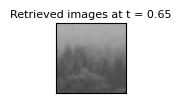

 28%|██▊       | 252/905 [00:00<00:02, 297.40it/s]

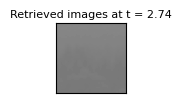

 53%|█████▎    | 477/905 [00:01<00:01, 272.99it/s]

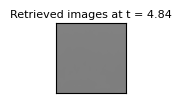

 77%|███████▋  | 693/905 [00:02<00:00, 263.45it/s]

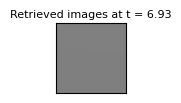

 97%|█████████▋| 877/905 [00:03<00:00, 298.81it/s]

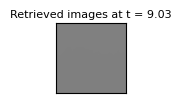

100%|█████████▉| 903/905 [00:03<00:00, 264.95it/s]




--------------------------------------------
Retrieving images with original tags...


  4%|▍         | 34/905 [00:00<00:02, 336.27it/s]

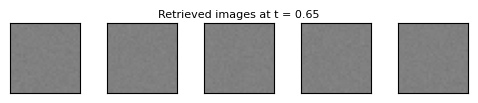

 26%|██▌       | 235/905 [00:00<00:01, 451.08it/s]

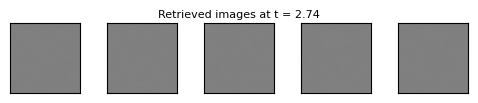

 48%|████▊     | 437/905 [00:01<00:01, 452.83it/s]

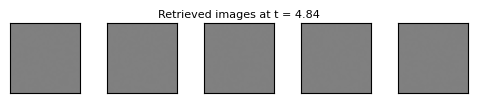

 72%|███████▏  | 652/905 [00:01<00:00, 466.03it/s]

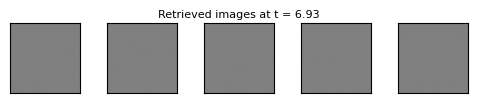

 97%|█████████▋| 876/905 [00:02<00:00, 489.26it/s]

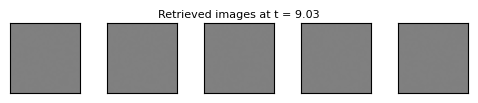

100%|█████████▉| 903/905 [00:02<00:00, 391.40it/s]


In [13]:
# Irrelevant cue 로 인출

print("Retrieving images with irrelevant tag...")
nn.retrieve_from_cue(irrelevant_cue, [mem_tags[-1]], decode_timings=t_daggers)  # irrelevant tag 로 인출

print("\n\n--------------------------------------------")
print("Retrieving images with original tags...")
nn.retrieve_from_cue(irrelevant_cue, mem_tags[:-1], decode_timings=t_daggers)  # original tags 로 인출